In [1]:

from mpl_toolkits.mplot3d import Axes3D
import datetime
from dateutil.relativedelta import relativedelta

import numpy as np
from numpy.random import randint, random
import scipy.stats
import math
import cv2
import imageio

from sklearn.cluster import KMeans
from sklearn import cluster
from scipy.cluster.vq import kmeans2
import matplotlib.pyplot as plt
from scipy import ndimage
%matplotlib inline

In [2]:


# input fllename >> output 3d array
def read_img(filename, mode, size):
    if mode == 'RGB':
        img_3d = imageio.imread(filename)
        #img_3d = cv2.imread(filename)
        #img_3d = cv2.cvtColor(img_3d, cv2.COLOR_BGR2RGB)
    elif mode == 'L':
        img_3d = imageio.imread(filename, mode = 'L')
    # Downsample the image
    #small = cv2.resize(img_3d, (0, 0), fx = size[0], fy = size[1])
    # Blurring effect to denoise
    #blur = cv2.blur(small, (4, 4))

    
    return img_3d


# input 3d array >> output 2d array
def flatten_img(img_3d, mode):
    if mode == 'RGB':
        x, y, z = img_3d.shape
        img_2d = img_3d.reshape(x*y, z)
        img_2d = np.array(img_2d, dtype = np.float)
    #elif mode == 'L':
        #x, y = img_3d.shape
        #img_2d = img_3d.reshape(x*y, 1)
        #img_2d = np.array(img_2d, dtype = np.float)
    return img_2d


# input 2d array >> output 3d array
def recover_img(img_2d, X, Y, mode = 'RGB', vis = False):
    #img_2d = cv2.resize(img_2d, (0, 0), fx=10, fy=10)
    if mode == 'RGB':
        img_2d = (img_2d * 255).astype(np.uint8)
        recover_img = img_2d.reshape(X, Y, 3)
    elif mode == 'L':
        recover_img = img_2d.reshape(X, Y)
    return recover_img


# input 2d array >> output estimated means, stds, pis
def kmeans_init(img, k):
    # means, labels = kmeans2(img, k)
    Kmean = KMeans(n_clusters=k)
    Kmean.fit(img)

    means = Kmean.cluster_centers_
    labels = Kmean.labels_

    try:
        means = np.array(means)
        cov = np.array([np.cov(img[labels == i].T) for i in range(k)])
        ids = set(labels)
        pis = np.array([np.sum([labels == i]) / len(labels) for i in ids])
    except Exception as ex:
        pass
    return means, cov, pis

def random_init(img, k):
    # For gray-scale
    if len(img.shape) == 1:
        means = randint(low = 0, high = 255, size = (k,1))
        cov = randint(low = 0, high = 500, size = k)
        pis = random(size = k)
    else:
        z = img.shape[1]
        means = randint(low = 0, high = 255, size = (k , z))
        pre_cov = randint(low=0, high=2, size=img.shape[0])
        cov = np.array([np.cov(img[pre_cov == i].T) for i in range(k)])
        pis = random(size = k)
    return means, cov, pis


# E-Step: Update Parameters
# update the conditional pdf - prob that pixel i given class j
def update_responsibility(img, means, cov, pis, k):
    # responsibilities: i th pixels, j th class
    # pis * gaussian.pdf
    responsibilities = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(img, mean=means[j], cov=cov[j], allow_singular=False) for j in range(k)]).T
    # normalize for each row
    norm = np.sum(responsibilities, axis = 1)
    # convert to column vector
    norm = np.reshape(norm, (len(norm), 1))
    responsibilities = responsibilities / norm
    return responsibilities


# update pi for each class of Gaussian model
def update_pis(responsibilities):
    pis = np.sum(responsibilities, axis = 0) / responsibilities.shape[0]
    return pis

# update means for each class of Gaussian model
def update_means(img, responsibilities):
    means = []
    class_n = responsibilities.shape[1]
    for j in range(class_n):
        weight = responsibilities[:, j] / np.sum(responsibilities[:, j])
        weight = np.reshape(weight, (1, len(weight)))
        means_j = weight.dot(img)
        means.append(means_j[0])
    means = np.array(means)
    return means

# update covariance matrix for each class of Gaussian model
def update_covariance(img, responsibilities, means):
    cov = []
    class_n = responsibilities.shape[1]
    for j in range(class_n):
        weight = responsibilities[:, j] / np.sum(responsibilities[:, j])
        weight = np.reshape(weight, (1, len(weight)))
        # Each pixels have a covariance matrice
        covs = [np.mat(i - means[j]).T * np.mat(i - means[j]) for i in img]
        # Weighted sum of covariance matrices
        cov_j = sum(weight[0][i] * covs[i] for i in range(len(weight[0])))
        cov.append(cov_j)
    cov = np.array(cov)
    return cov


# M-step: choose a label that maximise the likelihood
def update_labels(responsibilities):
    labels = np.argmax(responsibilities, axis = 1)
    return labels


def update_loglikelihood(img, means, cov, pis, k):
    pdf = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(img, mean=means[j], cov=cov[j], allow_singular=False) for j in range(k)])
    log_ll = np.log(np.sum(pdf, axis = 0))
    log_ll_sum = np.sum(log_ll)
    return log_ll_sum


def EM_cluster(img, k, random = False, error = 10e-4, iter_n = 9999):
    #  init setting
    cnt = 0
    likelihood_arr = []
    means_arr = []
    if not random:
        # Initialise E-Step by KMeans
        means, cov, pis = kmeans_init(img, k)

    else:
        means, cov, pis = random_init(img, k)
    #print(means, cov, pis)
    likelihood = 0
    new_likelihood = 2
    means_arr.append(means)
    responsibilities = update_responsibility(img, means, cov, pis, k)
    while (abs(likelihood - new_likelihood) > error) and (cnt != iter_n):
        start_dt = datetime.datetime.now()
        cnt += 1
        likelihood = new_likelihood
        # M-Step
        labels = update_labels(responsibilities)
        # E-step
        responsibilities = update_responsibility(img, means, cov, pis, k)
        means = update_means(img, responsibilities)
        cov = update_covariance(img, responsibilities, means)
        pis = update_pis(responsibilities)
        new_likelihood = update_loglikelihood(img, means, cov, pis, k)
        likelihood_arr.append(new_likelihood)
        #end_dt = datetime.datetime.now()
        #diff = relativedelta(end_dt, start_dt)
        print("iter: %s" % (cnt))
        print("erro:" + str(abs(likelihood - new_likelihood)))
        print("log-likelihood = {}".format(new_likelihood))
        # Store means stat
        means_arr.append(means)
    likelihood_arr = np.array(likelihood_arr)
    print('Converge at iteration {}'.format(cnt + 1))
    return labels, means, cov, pis, likelihood_arr, means_arr

In [3]:
def get_pdf(y, means, cov, pis, k):
    pdf_arr = np.array([pis[j] * scipy.stats.multivariate_normal.pdf(y, mean=means[j], cov=cov[j], allow_singular=False) for j in range(k)])
    pdf = np.sum(pdf_arr)
    return pdf

In [4]:
FILENAME_LIST = ['/Users/tony/Desktop/498 hwk/hw5/RobertMixed03.jpg', '/Users/tony/Desktop/498 hwk/hw5/smallstrelitzia.jpg', '/Users/tony/Desktop/498 hwk/hw5/smallsunset.jpg']

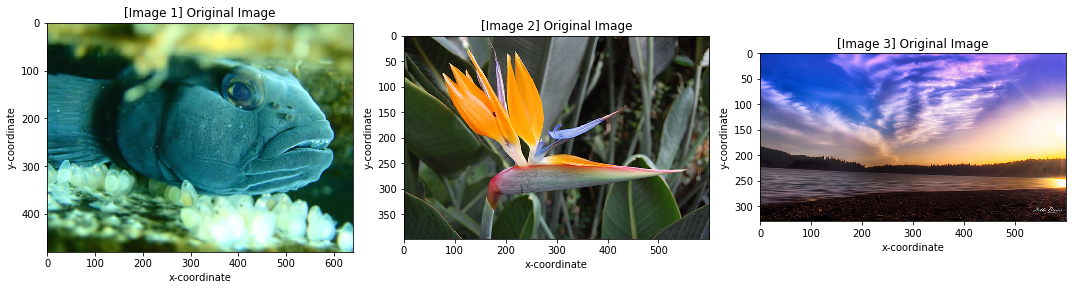

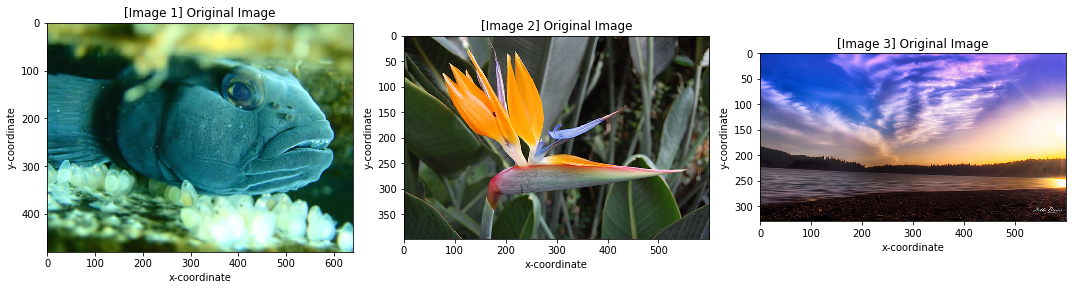

In [5]:
# Visualize demo images
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,15))
ax_list = [ax1, ax2, ax3]
rgb_img_list = []
dim_img_list = []
i = 1
for filename, ax in zip(FILENAME_LIST, ax_list):
    rgb_img = read_img(filename = filename, mode = 'RGB', size = (0.5, 0.5))
    x, y, z = rgb_img.shape
    # Store dimension for each image
    dim_img_list.append((x,y,z))
    # Store img 
    rgb_img_list.append(rgb_img)
    ax.imshow(rgb_img)
    ax.set_title('[Image {}] Original Image'.format(i))
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1

plt.tight_layout()
fig.savefig('orig_images.pdf')

In [6]:
img_list = [flatten_img(image, mode = 'RGB') for image in rgb_img_list]

In [7]:
# normalize the pixels by dividing them by 255
def normalize(img_list):
    img_list = np.true_divide(img_list, 255)
    return img_list

In [8]:
img_list = normalize(img_list)
img_list

array([array([[0.59215686, 0.74901961, 0.41176471],
       [0.58823529, 0.74509804, 0.40784314],
       [0.58431373, 0.74117647, 0.40392157],
       ...,
       [0.38823529, 0.67058824, 0.72941176],
       [0.34901961, 0.61568627, 0.69803922],
       [0.31764706, 0.57647059, 0.67058824]]),
       array([[0.08235294, 0.08627451, 0.0627451 ],
       [0.08627451, 0.09019608, 0.06666667],
       [0.09411765, 0.09803922, 0.0745098 ],
       ...,
       [0.14901961, 0.16862745, 0.18039216],
       [0.16078431, 0.18039216, 0.19215686],
       [0.19215686, 0.21568627, 0.21568627]]),
       array([[0.05098039, 0.21176471, 0.66666667],
       [0.05490196, 0.21568627, 0.67058824],
       [0.05490196, 0.21960784, 0.68235294],
       ...,
       [0.17647059, 0.12156863, 0.12156863],
       [0.17647059, 0.11372549, 0.11372549],
       [0.15294118, 0.05098039, 0.0627451 ]])], dtype=object)

array([array([[0.59215686, 0.74901961, 0.41176471],
       [0.58823529, 0.74509804, 0.40784314],
       [0.58431373, 0.74117647, 0.40392157],
       ...,
       [0.38823529, 0.67058824, 0.72941176],
       [0.34901961, 0.61568627, 0.69803922],
       [0.31764706, 0.57647059, 0.67058824]]),
       array([[0.08235294, 0.08627451, 0.0627451 ],
       [0.08627451, 0.09019608, 0.06666667],
       [0.09411765, 0.09803922, 0.0745098 ],
       ...,
       [0.14901961, 0.16862745, 0.18039216],
       [0.16078431, 0.18039216, 0.19215686],
       [0.19215686, 0.21568627, 0.21568627]]),
       array([[0.05098039, 0.21176471, 0.66666667],
       [0.05490196, 0.21568627, 0.67058824],
       [0.05490196, 0.21960784, 0.68235294],
       ...,
       [0.17647059, 0.12156863, 0.12156863],
       [0.17647059, 0.11372549, 0.11372549],
       [0.15294118, 0.05098039, 0.0627451 ]])], dtype=object)

In [9]:
# Init container
likelihood_arr_list = []
means_arr_list = []
cov_arr_list = []
pis_arr_list = []
em_img_list = []
means_list = []

for img, dim in zip(img_list, dim_img_list):
    labels, means, cov, pis, likelihood_arr, means_arr = EM_cluster(img, 10, error = 0.001)
    means = np.array([element[0] for element in means])
    cov = [element[0][0] for element in cov]
    em_img = means[labels]
    recover_img = em_img.reshape(dim[0], dim[1])
    # store required stat
    likelihood_arr_list.append(likelihood_arr)
    means_arr_list.append(means_arr)
    cov_arr_list.append(cov)
    pis_arr_list.append(pis)
    em_img_list.append(recover_img)
    means_list.append(means)

iter: 1
erro:980628.1340834246
log-likelihood = 980630.1340834246
iter: 1
erro:980628.1340834246
log-likelihood = 980630.1340834246
iter: 2
erro:15278.864486257546
log-likelihood = 995908.9985696821
iter: 2
erro:15278.864486257546
log-likelihood = 995908.9985696821
iter: 3
erro:10275.864380210638
log-likelihood = 1006184.8629498928
iter: 3
erro:10275.864380210638
log-likelihood = 1006184.8629498928
iter: 4
erro:8850.432977975695
log-likelihood = 1015035.2959278685
iter: 4
erro:8850.432977975695
log-likelihood = 1015035.2959278685
iter: 5
erro:7609.956997188856
log-likelihood = 1022645.2529250573
iter: 5
erro:7609.956997188856
log-likelihood = 1022645.2529250573
iter: 6
erro:6022.37228991068
log-likelihood = 1028667.625214968
iter: 6
erro:6022.37228991068
log-likelihood = 1028667.625214968
iter: 7
erro:4323.952771312674
log-likelihood = 1032991.5779862807
iter: 7
erro:4323.952771312674
log-likelihood = 1032991.5779862807
iter: 8
erro:2878.2695177946007
log-likelihood = 1035869.847504075

iter: 61
erro:1.222579397726804
log-likelihood = 1049096.5828871978
iter: 62
erro:1.0751046654768288
log-likelihood = 1049097.6579918633
iter: 62
erro:1.0751046654768288
log-likelihood = 1049097.6579918633
iter: 63
erro:0.9485406121239066
log-likelihood = 1049098.6065324754
iter: 63
erro:0.9485406121239066
log-likelihood = 1049098.6065324754
iter: 64
erro:0.8396939467638731
log-likelihood = 1049099.4462264222
iter: 64
erro:0.8396939467638731
log-likelihood = 1049099.4462264222
iter: 65
erro:0.7458768067881465
log-likelihood = 1049100.192103229
iter: 65
erro:0.7458768067881465
log-likelihood = 1049100.192103229
iter: 66
erro:0.6648245335090905
log-likelihood = 1049100.8569277625
iter: 66
erro:0.6648245335090905
log-likelihood = 1049100.8569277625
iter: 67
erro:0.5946273002773523
log-likelihood = 1049101.4515550628
iter: 67
erro:0.5946273002773523
log-likelihood = 1049101.4515550628
iter: 68
erro:0.5336731378920376
log-likelihood = 1049101.9852282007
iter: 68
erro:0.5336731378920376
log-

iter: 120
erro:0.018225944600999355
log-likelihood = 1049108.277079628
iter: 121
erro:0.017272715223953128
log-likelihood = 1049108.2943523433
iter: 121
erro:0.017272715223953128
log-likelihood = 1049108.2943523433
iter: 122
erro:0.01636944618076086
log-likelihood = 1049108.3107217895
iter: 122
erro:0.01636944618076086
log-likelihood = 1049108.3107217895
iter: 123
erro:0.015513472259044647
log-likelihood = 1049108.3262352617
iter: 123
erro:0.015513472259044647
log-likelihood = 1049108.3262352617
iter: 124
erro:0.014702278189361095
log-likelihood = 1049108.34093754
iter: 124
erro:0.014702278189361095
log-likelihood = 1049108.34093754
iter: 125
erro:0.013933493057265878
log-likelihood = 1049108.354871033
iter: 125
erro:0.013933493057265878
log-likelihood = 1049108.354871033
iter: 126
erro:0.013204873073846102
log-likelihood = 1049108.368075906
iter: 126
erro:0.013204873073846102
log-likelihood = 1049108.368075906
iter: 127
erro:0.012514305301010609
log-likelihood = 1049108.3805902114
ite

iter: 3
erro:8923.450776601443
log-likelihood = 946697.5296697082
iter: 4
erro:5923.851700575789
log-likelihood = 952621.381370284
iter: 4
erro:5923.851700575789
log-likelihood = 952621.381370284
iter: 5
erro:4282.1206941714045
log-likelihood = 956903.5020644554
iter: 5
erro:4282.1206941714045
log-likelihood = 956903.5020644554
iter: 6
erro:3279.127010468859
log-likelihood = 960182.6290749243
iter: 6
erro:3279.127010468859
log-likelihood = 960182.6290749243
iter: 7
erro:2495.426844136091
log-likelihood = 962678.0559190604
iter: 7
erro:2495.426844136091
log-likelihood = 962678.0559190604
iter: 8
erro:1871.9505868859123
log-likelihood = 964550.0065059463
iter: 8
erro:1871.9505868859123
log-likelihood = 964550.0065059463
iter: 9
erro:1437.0095638385974
log-likelihood = 965987.0160697849
iter: 9
erro:1437.0095638385974
log-likelihood = 965987.0160697849
iter: 10
erro:1144.2147532372037
log-likelihood = 967131.2308230221
iter: 10
erro:1144.2147532372037
log-likelihood = 967131.2308230221
it

iter: 64
erro:91.1315223389538
log-likelihood = 984928.0718708643
iter: 65
erro:87.62849578319583
log-likelihood = 985015.7003666474
iter: 65
erro:87.62849578319583
log-likelihood = 985015.7003666474
iter: 66
erro:84.00654583843425
log-likelihood = 985099.7069124859
iter: 66
erro:84.00654583843425
log-likelihood = 985099.7069124859
iter: 67
erro:80.31369211932179
log-likelihood = 985180.0206046052
iter: 67
erro:80.31369211932179
log-likelihood = 985180.0206046052
iter: 68
erro:76.6006269651698
log-likelihood = 985256.6212315704
iter: 68
erro:76.6006269651698
log-likelihood = 985256.6212315704
iter: 69
erro:72.91613434872124
log-likelihood = 985329.5373659191
iter: 69
erro:72.91613434872124
log-likelihood = 985329.5373659191
iter: 70
erro:69.30378686555196
log-likelihood = 985398.8411527846
iter: 70
erro:69.30378686555196
log-likelihood = 985398.8411527846
iter: 71
erro:65.79990718595218
log-likelihood = 985464.6410599706
iter: 71
erro:65.79990718595218
log-likelihood = 985464.641059970

iter: 125
erro:5.070320393308066
log-likelihood = 986702.0608308535
iter: 126
erro:4.8350454944884405
log-likelihood = 986706.895876348
iter: 126
erro:4.8350454944884405
log-likelihood = 986706.895876348
iter: 127
erro:4.612038180814125
log-likelihood = 986711.5079145288
iter: 127
erro:4.612038180814125
log-likelihood = 986711.5079145288
iter: 128
erro:4.40068520756904
log-likelihood = 986715.9085997364
iter: 128
erro:4.40068520756904
log-likelihood = 986715.9085997364
iter: 129
erro:4.200396138941869
log-likelihood = 986720.1089958753
iter: 129
erro:4.200396138941869
log-likelihood = 986720.1089958753
iter: 130
erro:4.010603693081066
log-likelihood = 986724.1195995684
iter: 130
erro:4.010603693081066
log-likelihood = 986724.1195995684
iter: 131
erro:3.830763851874508
log-likelihood = 986727.9503634203
iter: 131
erro:3.830763851874508
log-likelihood = 986727.9503634203
iter: 132
erro:3.6603558133356273
log-likelihood = 986731.6107192336
iter: 132
erro:3.6603558133356273
log-likelihood 

iter: 185
erro:0.617530012037605
log-likelihood = 986812.4584677161
iter: 186
erro:0.6031649456126615
log-likelihood = 986813.0616326617
iter: 186
erro:0.6031649456126615
log-likelihood = 986813.0616326617
iter: 187
erro:0.5892685860162601
log-likelihood = 986813.6509012477
iter: 187
erro:0.5892685860162601
log-likelihood = 986813.6509012477
iter: 188
erro:0.57581919466611
log-likelihood = 986814.2267204424
iter: 188
erro:0.57581919466611
log-likelihood = 986814.2267204424
iter: 189
erro:0.5627962651196867
log-likelihood = 986814.7895167075
iter: 189
erro:0.5627962651196867
log-likelihood = 986814.7895167075
iter: 190
erro:0.5501804476371035
log-likelihood = 986815.3396971552
iter: 190
erro:0.5501804476371035
log-likelihood = 986815.3396971552
iter: 191
erro:0.5379534844541922
log-likelihood = 986815.8776506396
iter: 191
erro:0.5379534844541922
log-likelihood = 986815.8776506396
iter: 192
erro:0.5260981424944475
log-likelihood = 986816.4037487821
iter: 192
erro:0.5260981424944475
log-l

iter: 245
erro:0.19032321241684258
log-likelihood = 986833.3633250493
iter: 245
erro:0.19032321241684258
log-likelihood = 986833.3633250493
iter: 246
erro:0.18715751997660846
log-likelihood = 986833.5504825693
iter: 246
erro:0.18715751997660846
log-likelihood = 986833.5504825693
iter: 247
erro:0.1840630688238889
log-likelihood = 986833.7345456381
iter: 247
erro:0.1840630688238889
log-likelihood = 986833.7345456381
iter: 248
erro:0.1810384183190763
log-likelihood = 986833.9155840564
iter: 248
erro:0.1810384183190763
log-likelihood = 986833.9155840564
iter: 249
erro:0.17808216670528054
log-likelihood = 986834.0936662231
iter: 249
erro:0.17808216670528054
log-likelihood = 986834.0936662231
iter: 250
erro:0.17519294272642583
log-likelihood = 986834.2688591658
iter: 250
erro:0.17519294272642583
log-likelihood = 986834.2688591658
iter: 251
erro:0.17236941307783127
log-likelihood = 986834.4412285789
iter: 251
erro:0.17236941307783127
log-likelihood = 986834.4412285789
iter: 252
erro:0.1696102

iter: 304
erro:0.09054059442132711
log-likelihood = 986840.8740476369
iter: 304
erro:0.09054059442132711
log-likelihood = 986840.8740476369
iter: 305
erro:0.0899119961541146
log-likelihood = 986840.963959633
iter: 305
erro:0.0899119961541146
log-likelihood = 986840.963959633
iter: 306
erro:0.08930781309027225
log-likelihood = 986841.0532674461
iter: 306
erro:0.08930781309027225
log-likelihood = 986841.0532674461
iter: 307
erro:0.08872771810274571
log-likelihood = 986841.1419951642
iter: 307
erro:0.08872771810274571
log-likelihood = 986841.1419951642
iter: 308
erro:0.08817139896564186
log-likelihood = 986841.2301665632
iter: 308
erro:0.08817139896564186
log-likelihood = 986841.2301665632
iter: 309
erro:0.08763855241704732
log-likelihood = 986841.3178051156
iter: 309
erro:0.08763855241704732
log-likelihood = 986841.3178051156
iter: 310
erro:0.0871288898633793
log-likelihood = 986841.4049340055
iter: 310
erro:0.0871288898633793
log-likelihood = 986841.4049340055
iter: 311
erro:0.086642134

iter: 363
erro:0.09031421435065567
log-likelihood = 986845.8473438767
iter: 363
erro:0.09031421435065567
log-likelihood = 986845.8473438767
iter: 364
erro:0.09098473470658064
log-likelihood = 986845.9383286114
iter: 364
erro:0.09098473470658064
log-likelihood = 986845.9383286114
iter: 365
erro:0.0916837661061436
log-likelihood = 986846.0300123775
iter: 365
erro:0.0916837661061436
log-likelihood = 986846.0300123775
iter: 366
erro:0.09241194929927588
log-likelihood = 986846.1224243268
iter: 366
erro:0.09241194929927588
log-likelihood = 986846.1224243268
iter: 367
erro:0.09316995728295296
log-likelihood = 986846.2155942841
iter: 367
erro:0.09316995728295296
log-likelihood = 986846.2155942841
iter: 368
erro:0.0939584958832711
log-likelihood = 986846.30955278
iter: 368
erro:0.0939584958832711
log-likelihood = 986846.30955278
iter: 369
erro:0.0947783071314916
log-likelihood = 986846.4043310871
iter: 369
erro:0.0947783071314916
log-likelihood = 986846.4043310871
iter: 370
erro:0.0956301683327

iter: 422
erro:0.2262175561627373
log-likelihood = 986853.9354931765
iter: 422
erro:0.2262175561627373
log-likelihood = 986853.9354931765
iter: 423
erro:0.23201194184366614
log-likelihood = 986854.1675051183
iter: 423
erro:0.23201194184366614
log-likelihood = 986854.1675051183
iter: 424
erro:0.23804779595229775
log-likelihood = 986854.4055529142
iter: 424
erro:0.23804779595229775
log-likelihood = 986854.4055529142
iter: 425
erro:0.2443373203277588
log-likelihood = 986854.6498902346
iter: 425
erro:0.2443373203277588
log-likelihood = 986854.6498902346
iter: 426
erro:0.2508934505749494
log-likelihood = 986854.9007836852
iter: 426
erro:0.2508934505749494
log-likelihood = 986854.9007836852
iter: 427
erro:0.2577299120603129
log-likelihood = 986855.1585135972
iter: 427
erro:0.2577299120603129
log-likelihood = 986855.1585135972
iter: 428
erro:0.26486127404496074
log-likelihood = 986855.4233748713
iter: 428
erro:0.26486127404496074
log-likelihood = 986855.4233748713
iter: 429
erro:0.27230300381

iter: 481
erro:2.339918892714195
log-likelihood = 986901.1996858545
iter: 482
erro:2.475723496172577
log-likelihood = 986903.6754093507
iter: 482
erro:2.475723496172577
log-likelihood = 986903.6754093507
iter: 483
erro:2.620532373082824
log-likelihood = 986906.2959417237
iter: 483
erro:2.620532373082824
log-likelihood = 986906.2959417237
iter: 484
erro:2.774899685406126
log-likelihood = 986909.0708414091
iter: 484
erro:2.774899685406126
log-likelihood = 986909.0708414091
iter: 485
erro:2.93939355481416
log-likelihood = 986912.010234964
iter: 485
erro:2.93939355481416
log-likelihood = 986912.010234964
iter: 486
erro:3.1145911391358823
log-likelihood = 986915.1248261031
iter: 486
erro:3.1145911391358823
log-likelihood = 986915.1248261031
iter: 487
erro:3.301072286325507
log-likelihood = 986918.4258983894
iter: 487
erro:3.301072286325507
log-likelihood = 986918.4258983894
iter: 488
erro:3.499411497381516
log-likelihood = 986921.9253098868
iter: 488
erro:3.499411497381516
log-likelihood = 

iter: 542
erro:3.6474236282519996
log-likelihood = 987361.9023831743
iter: 542
erro:3.6474236282519996
log-likelihood = 987361.9023831743
iter: 543
erro:3.369113847031258
log-likelihood = 987365.2714970213
iter: 543
erro:3.369113847031258
log-likelihood = 987365.2714970213
iter: 544
erro:3.1101981323445216
log-likelihood = 987368.3816951537
iter: 544
erro:3.1101981323445216
log-likelihood = 987368.3816951537
iter: 545
erro:2.8699379664612934
log-likelihood = 987371.2516331201
iter: 545
erro:2.8699379664612934
log-likelihood = 987371.2516331201
iter: 546
erro:2.6474833148531616
log-likelihood = 987373.899116435
iter: 546
erro:2.6474833148531616
log-likelihood = 987373.899116435
iter: 547
erro:2.441909004119225
log-likelihood = 987376.3410254391
iter: 547
erro:2.441909004119225
log-likelihood = 987376.3410254391
iter: 548
erro:2.252245345734991
log-likelihood = 987378.5932707848
iter: 548
erro:2.252245345734991
log-likelihood = 987378.5932707848
iter: 549
erro:2.0775033325189725
log-like

iter: 601
erro:0.08373174082953483
log-likelihood = 987407.5121988553
iter: 602
erro:0.0801585145527497
log-likelihood = 987407.5923573698
iter: 602
erro:0.0801585145527497
log-likelihood = 987407.5923573698
iter: 603
erro:0.07677455293014646
log-likelihood = 987407.6691319228
iter: 603
erro:0.07677455293014646
log-likelihood = 987407.6691319228
iter: 604
erro:0.07356834481470287
log-likelihood = 987407.7427002676
iter: 604
erro:0.07356834481470287
log-likelihood = 987407.7427002676
iter: 605
erro:0.07052922889124602
log-likelihood = 987407.8132294965
iter: 605
erro:0.07052922889124602
log-likelihood = 987407.8132294965
iter: 606
erro:0.06764732231386006
log-likelihood = 987407.8808768188
iter: 606
erro:0.06764732231386006
log-likelihood = 987407.8808768188
iter: 607
erro:0.06491345481481403
log-likelihood = 987407.9457902736
iter: 607
erro:0.06491345481481403
log-likelihood = 987407.9457902736
iter: 608
erro:0.06231911189388484
log-likelihood = 987408.0081093855
iter: 608
erro:0.06231

iter: 660
erro:0.018063146038912237
log-likelihood = 987409.5701180762
iter: 660
erro:0.018063146038912237
log-likelihood = 987409.5701180762
iter: 661
erro:0.018034717300906777
log-likelihood = 987409.5881527935
iter: 661
erro:0.018034717300906777
log-likelihood = 987409.5881527935
iter: 662
erro:0.018021849798969924
log-likelihood = 987409.6061746433
iter: 662
erro:0.018021849798969924
log-likelihood = 987409.6061746433
iter: 663
erro:0.018024219898507
log-likelihood = 987409.6241988632
iter: 663
erro:0.018024219898507
log-likelihood = 987409.6241988632
iter: 664
erro:0.018041525152511895
log-likelihood = 987409.6422403883
iter: 664
erro:0.018041525152511895
log-likelihood = 987409.6422403883
iter: 665
erro:0.018073480343446136
log-likelihood = 987409.6603138687
iter: 665
erro:0.018073480343446136
log-likelihood = 987409.6603138687
iter: 666
erro:0.018119820742867887
log-likelihood = 987409.6784336894
iter: 666
erro:0.018119820742867887
log-likelihood = 987409.6784336894
iter: 667
er

iter: 718
erro:0.03756943764165044
log-likelihood = 987410.9969663795
iter: 719
erro:0.038250218611210585
log-likelihood = 987411.0352165981
iter: 719
erro:0.038250218611210585
log-likelihood = 987411.0352165981
iter: 720
erro:0.03894141281489283
log-likelihood = 987411.0741580109
iter: 720
erro:0.03894141281489283
log-likelihood = 987411.0741580109
iter: 721
erro:0.03964282968081534
log-likelihood = 987411.1138008406
iter: 721
erro:0.03964282968081534
log-likelihood = 987411.1138008406
iter: 722
erro:0.040354262688197196
log-likelihood = 987411.1541551033
iter: 722
erro:0.040354262688197196
log-likelihood = 987411.1541551033
iter: 723
erro:0.04107548319734633
log-likelihood = 987411.1952305865
iter: 723
erro:0.04107548319734633
log-likelihood = 987411.1952305865
iter: 724
erro:0.04180624440778047
log-likelihood = 987411.2370368309
iter: 724
erro:0.04180624440778047
log-likelihood = 987411.2370368309
iter: 725
erro:0.04254627681802958
log-likelihood = 987411.2795831077
iter: 725
erro:0

iter: 777
erro:0.07759842742234468
log-likelihood = 987414.543546542
iter: 778
erro:0.07773350388742983
log-likelihood = 987414.6212800458
iter: 778
erro:0.07773350388742983
log-likelihood = 987414.6212800458
iter: 779
erro:0.07782889856025577
log-likelihood = 987414.6991089444
iter: 779
erro:0.07782889856025577
log-likelihood = 987414.6991089444
iter: 780
erro:0.07788393890950829
log-likelihood = 987414.7769928833
iter: 780
erro:0.07788393890950829
log-likelihood = 987414.7769928833
iter: 781
erro:0.07789803179912269
log-likelihood = 987414.8548909151
iter: 781
erro:0.07789803179912269
log-likelihood = 987414.8548909151
iter: 782
erro:0.07787065987940878
log-likelihood = 987414.932761575
iter: 782
erro:0.07787065987940878
log-likelihood = 987414.932761575
iter: 783
erro:0.07780139241367579
log-likelihood = 987415.0105629674
iter: 783
erro:0.07780139241367579
log-likelihood = 987415.0105629674
iter: 784
erro:0.07768988248426467
log-likelihood = 987415.0882528499
iter: 784
erro:0.077689

iter: 836
erro:0.032646990730427206
log-likelihood = 987418.1365505042
iter: 837
erro:0.031661715824157
log-likelihood = 987418.1682122201
iter: 837
erro:0.031661715824157
log-likelihood = 987418.1682122201
iter: 838
erro:0.03069347469136119
log-likelihood = 987418.1989056948
iter: 838
erro:0.03069347469136119
log-likelihood = 987418.1989056948
iter: 839
erro:0.029742792015895247
log-likelihood = 987418.2286484868
iter: 839
erro:0.029742792015895247
log-likelihood = 987418.2286484868
iter: 840
erro:0.028810129850171506
log-likelihood = 987418.2574586166
iter: 840
erro:0.028810129850171506
log-likelihood = 987418.2574586166
iter: 841
erro:0.027895894018001854
log-likelihood = 987418.2853545106
iter: 841
erro:0.027895894018001854
log-likelihood = 987418.2853545106
iter: 842
erro:0.027000430854968727
log-likelihood = 987418.3123549415
iter: 842
erro:0.027000430854968727
log-likelihood = 987418.3123549415
iter: 843
erro:0.02612403396051377
log-likelihood = 987418.3384789755
iter: 843
erro:

iter: 894
erro:0.003576585091650486
log-likelihood = 987418.9270044722
iter: 895
erro:0.0034296015510335565
log-likelihood = 987418.9304340738
iter: 895
erro:0.0034296015510335565
log-likelihood = 987418.9304340738
iter: 896
erro:0.0032885719556361437
log-likelihood = 987418.9337226457
iter: 896
erro:0.0032885719556361437
log-likelihood = 987418.9337226457
iter: 897
erro:0.003153269295580685
log-likelihood = 987418.936875915
iter: 897
erro:0.003153269295580685
log-likelihood = 987418.936875915
iter: 898
erro:0.003023473545908928
log-likelihood = 987418.9398993886
iter: 898
erro:0.003023473545908928
log-likelihood = 987418.9398993886
iter: 899
erro:0.002898972714319825
log-likelihood = 987418.9427983613
iter: 899
erro:0.002898972714319825
log-likelihood = 987418.9427983613
iter: 900
erro:0.0027795620262622833
log-likelihood = 987418.9455779233
iter: 900
erro:0.0027795620262622833
log-likelihood = 987418.9455779233
iter: 901
erro:0.0026650417130440474
log-likelihood = 987418.948242965
it

iter: 28
erro:864.3993243607692
log-likelihood = 648463.0208204502
iter: 29
erro:869.4932182340417
log-likelihood = 649332.5140386842
iter: 29
erro:869.4932182340417
log-likelihood = 649332.5140386842
iter: 30
erro:712.9402255041059
log-likelihood = 650045.4542641883
iter: 30
erro:712.9402255041059
log-likelihood = 650045.4542641883
iter: 31
erro:529.9176621786319
log-likelihood = 650575.3719263669
iter: 31
erro:529.9176621786319
log-likelihood = 650575.3719263669
iter: 32
erro:381.57613566936925
log-likelihood = 650956.9480620363
iter: 32
erro:381.57613566936925
log-likelihood = 650956.9480620363
iter: 33
erro:266.79773636360187
log-likelihood = 651223.7457983999
iter: 33
erro:266.79773636360187
log-likelihood = 651223.7457983999
iter: 34
erro:183.45966919779312
log-likelihood = 651407.2054675977
iter: 34
erro:183.45966919779312
log-likelihood = 651407.2054675977
iter: 35
erro:126.73006511491258
log-likelihood = 651533.9355327126
iter: 35
erro:126.73006511491258
log-likelihood = 65153

iter: 89
erro:0.0028550311690196395
log-likelihood = 651926.5107014624
iter: 89
erro:0.0028550311690196395
log-likelihood = 651926.5107014624
iter: 90
erro:0.0024084539618343115
log-likelihood = 651926.5131099164
iter: 90
erro:0.0024084539618343115
log-likelihood = 651926.5131099164
iter: 91
erro:0.0020325375953689218
log-likelihood = 651926.515142454
iter: 91
erro:0.0020325375953689218
log-likelihood = 651926.515142454
iter: 92
erro:0.0017159394919872284
log-likelihood = 651926.5168583934
iter: 92
erro:0.0017159394919872284
log-likelihood = 651926.5168583934
iter: 93
erro:0.0014491697074845433
log-likelihood = 651926.5183075632
iter: 93
erro:0.0014491697074845433
log-likelihood = 651926.5183075632
iter: 94
erro:0.001224282430484891
log-likelihood = 651926.5195318456
iter: 94
erro:0.001224282430484891
log-likelihood = 651926.5195318456
iter: 95
erro:0.001034620450809598
log-likelihood = 651926.520566466
iter: 95
erro:0.001034620450809598
log-likelihood = 651926.520566466
iter: 96
erro:

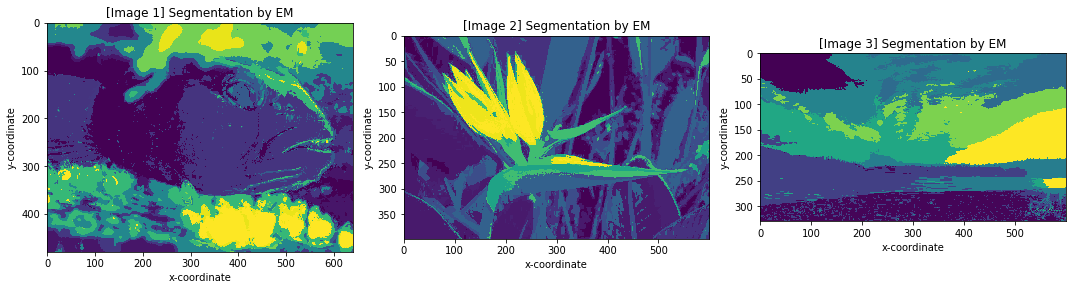

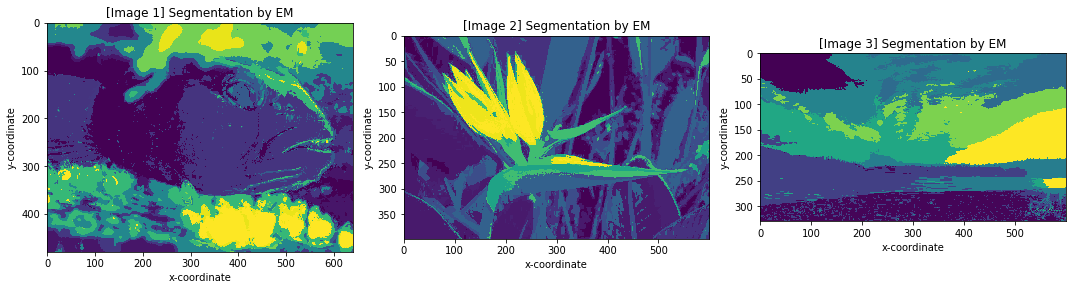

In [10]:
# supposedly the images after replacing kmeans em
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,15))
ax_list = [ax1, ax2, ax3]
i = 1
for em_img, ax, dim in zip(em_img_list, ax_list, dim_img_list):
    ax.imshow(em_img)
    ax.set_title('[Image {}] Segmentation by EM'.format(i))
    ax.axes.set_xlabel('x-coordinate')
    ax.axes.set_ylabel('y-coordinate')
    i += 1
    
plt.tight_layout()
fig.savefig('em_images.pdf')